# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [76]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [24]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [25]:
spaceship.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [26]:
spaceship = spaceship.dropna()
spaceship

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [27]:
spaceship = spaceship.drop(columns=['PassengerId', 'Name'])

In [28]:
spaceship['Cabin']= spaceship['Cabin'].str[0]
spaceship.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [29]:
spaceship = pd.get_dummies(spaceship, columns=['HomePlanet', 'Cabin', 'Destination'])


In [30]:
spaceship.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'],
      dtype='object')

In [56]:
spaceship

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False
8689,True,18.0,False,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False
8690,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,True,False,False,False,False,False,False,False,False,True,False,False,False,True
8691,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [34]:
features = spaceship[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']]
target = spaceship['Transported']

**Perform Train Test Split**

In [164]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

In [165]:
normalizer = MinMaxScaler()

normalizer.fit(X_train)

MinMaxScaler()

In [166]:
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [167]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,1.0,0.405063,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.050633,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.379747,0.0,0.00000,0.007916,0.000000,0.051276,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.215190,0.0,0.00131,0.000000,0.046111,0.016378,0.000049,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.329114,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

- Bagging and Pasting

In [171]:
bagging_reg = BaggingClassifier(DecisionTreeClassifier(max_depth=20),
                               n_estimators=100,
                               random_state=0,
                               max_samples = 1000)

In [172]:
bagging_reg.fit(X_train_norm, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                  max_samples=1000, n_estimators=100, random_state=0)

In [187]:
pred = bagging_reg.predict(X_test_norm)

print("Accuracy score", accuracy_score(y_test, pred))
print("Recall score", recall_score(y_test, pred))
print("Precision score", precision_score(y_test, pred))
print("F1 score", f1_score(y_test, pred))

Accuracy score 0.7934947049924357
Recall score 0.7866868381240545
Precision score 0.7975460122699386
F1 score 0.7920792079207921


/Users/gali/Documents/ironhack/environment_ironhack/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [78]:
confusion_matrix(y_test, pred)

array([[515, 146],
       [133, 528]])

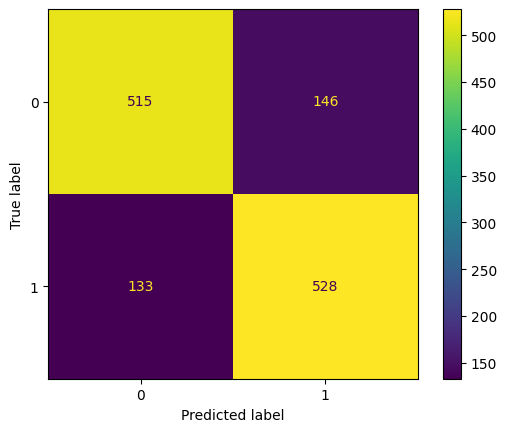

In [81]:
ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()

- Random Forests

In [177]:
forest = RandomForestClassifier(n_estimators=100,
                                random_state=0,
                                max_depth=10)

In [178]:
forest.fit(X_train_norm, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [179]:
pred = forest.predict(X_test_norm)

print("Accuracy score", accuracy_score(y_test, pred))
print("F1 score", f1_score(y_test, pred))

Accuracy score 0.7813918305597579
F1 score 0.7848101265822784


/Users/gali/Documents/ironhack/environment_ironhack/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


- Gradient Boosting

In [180]:
gb_reg = GradientBoostingClassifier(max_depth=20,
                                    random_state=0,
                                    n_estimators=100)

In [181]:
gb_reg.fit(X_train_norm, y_train)

GradientBoostingClassifier(max_depth=20, random_state=0)

In [182]:
pred = gb_reg.predict(X_test_norm)

print("Accuracy score", accuracy_score(y_test, pred))
print("F1 score", f1_score(y_test, pred))

Accuracy score 0.7859304084720121
F1 score 0.7899034892353378


/Users/gali/Documents/ironhack/environment_ironhack/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [183]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(X_train_norm, y_train)

xgb.score(X_test_norm, y_test)

0.7889561270801816

- Adaptive Boosting

In [184]:
ada_reg = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                             
                                random_state=0,
                                n_estimators=100)

In [185]:
ada_reg.fit(X_train_norm, y_train)

/Users/gali/Documents/ironhack/environment_ironhack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   n_estimators=100, random_state=0)

In [186]:
pred = ada_reg.predict(X_test_norm)

print("Accuracy score", accuracy_score(y_test, pred))
print("F1 score", f1_score(y_test, pred))

Accuracy score 0.7662632375189108
F1 score 0.7719557195571956


/Users/gali/Documents/ironhack/environment_ironhack/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Which model is the best and why?

In [ ]:
#comment here